In [1]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "helpers/")
from lstm import Model, Optimization
from aux_functions import (dateindex_from_weeknum, dateindex_from_timestamp, ts_train_test_split, 
                           cols_with_most_corr, lagged_corr, lagged_corr_matrix, 
                           cols_with_most_lagged_corr, calculate_pvalues, cols_with_sig_pval, corr_feature_selection)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency, kruskal
# Packages of forecasting models
from stldecompose import decompose, forecast
from statsmodels.tsa.statespace.sarimax import SARIMAX
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)
import pmdarima as pm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Auxilliary functions

In [2]:
def augment_store_data (store_df, loc_weather_df):
    ## PREPROCESS THE ORIGINAL STORE DATA
    
    # Drop unnamed column and listino column, we won't be using those
    store_df = store_df.drop(["Unnamed: 0", "listino"], axis=1)

    # Build datetime index
    store_df["time"] = [dateindex_from_weeknum(week_year[0], week_year[1]) for week_year in store_df[["settimana", "anno"]].values]
    store_df = store_df.set_index(["time"])
    store_df.index = pd.to_datetime(store_df.index) # make ts

    # Sort the data based on the new time index
    store_df.sort_index(inplace=True)

    # Aggregate the data to get the total sales of each week
    store_weekly_totals = store_df.groupby(pd.Grouper(freq = "W-MON")).agg({
        "vendita": np.sum,
        "settimana": np.min, 
        "anno": np.min,
    })

    # Check for NAN values and replace them if they are present
    nan_indices = store_weekly_totals[store_weekly_totals.isnull().any(axis=1)].index
    for nan_idx in nan_indices:
        store_weekly_totals.loc[nan_idx, "vendita"] = np.mean(store_weekly_totals.loc[:nan_idx,"vendita"].values)
        store_weekly_totals.loc[nan_idx, "settimana"] = nan_idx.week
        store_weekly_totals.loc[nan_idx, "anno"] = nan_idx.year
        
    # Drop 2020 data (we won't be using them)
    store_weekly_totals.drop(store_weekly_totals.loc["2020"].index, inplace=True)
    # Drop the year data (we won't be using it)
    store_weekly_totals.drop("anno", axis=1, inplace=True)

    ## PREPROCESS AND ADD WEATHER DATA
   
    # We can't really group the different weather fenomenons happening each day that column can't be used
    # Also the rain and average pressure cols are useless, they only have values of 0 or nan.
    # We won't be using those either 
    # We won't be using the following cols (nan vals or categorical)
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "FENOMENI", "PIOGGIA mm", "PRESSIONEMEDIA mb"], axis=1)
    loc_weather_df = loc_weather_df.loc[store_weekly_totals.index[0]:,:]
    
    # Group data by week (starting with the date 01-01 of the the first year) and aggregate by mean
    loc_weather_df = loc_weather_df.groupby([pd.Grouper(freq = "W-MON")]).agg(np.mean)
    loc_weather_df["PRESSIONESLM mb"] = loc_weather_df["PRESSIONESLM mb"].fillna(np.mean(loc_weather_df["PRESSIONESLM mb"]))
    
    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_weekly_weather_augmented = store_weekly_totals.copy(deep=True)
    week_nr_values = store_weekly_totals.settimana.values
    store_weekly_weather_augmented["sin_week"] =  np.sin((week_nr_values/53) * 2*np.pi)
    store_weekly_weather_augmented["cos_week"] = np.cos((week_nr_values/53) * 2*np.pi)
    store_weekly_weather_augmented["sincos_week"] = np.sin((week_nr_values/53) * 2*np.pi) * np.cos((week_nr_values/53) * 2*np.pi)
    store_weekly_weather_augmented.drop("settimana", axis=1, inplace=True) # drop the actual week number values now
    store_weekly_totals.drop("settimana", axis=1, inplace=True) # drop the actual week number values now

    for w_col in loc_weather_df.columns:
        store_weekly_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
    
    nan_indices = store_weekly_weather_augmented[loc_weather_df.isnull().any(axis=1)].index
    for nan_idx in nan_indices:
        n_days_before = nan_idx - timedelta(weeks=3)
        before_nan = nan_idx - timedelta(weeks=1)
        store_weekly_weather_augmented.fillna(np.mean(store_weekly_weather_augmented.loc[n_days_before:before_nan]), inplace=True)
    
    return store_weekly_totals, store_weekly_weather_augmented

# Load and clean data

In [3]:
## Store sales data

# Milan data
milan_data_df = pd.read_csv("../datasets/dati_nunalie/MILANO/ARESE.csv")

# Turin data
turin_data_df = pd.read_csv("../datasets/dati_nunalie/TORINO/TORIN.csv")

# Rome data
rome_data_df = pd.read_csv("../datasets/dati_nunalie/ROMA/RMNAZ.csv")
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TIBUR.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC1.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC2.csv"))


print("Milan sales data")
print(milan_data_df.head())
print("\n")
print("Turin sales data")
print(turin_data_df.head())
print("\n")
print("Rome sales data")
print(rome_data_df.head())
print("\n\n")

## Exogenous weather data

# weather
parser = lambda date: datetime.strptime(date, '%d/%m/%Y')
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)
rome_weather_df = pd.read_csv("../datasets/Eso_data/weather/roma_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)

Milan sales data
   Unnamed: 0 codice esterno  vendita  settimana  anno taglia negozio listino
0        8313  16SF181BNE-16        1         16  2016     XS   ARESE     LSI
1        8511  VA515233NE-16        1         16  2016     XS   ARESE     LSI
2        8569  16SF181BBL-16        1         16  2016      S   ARESE     LSI
3        8807   ZR121FABI-16        2         16  2016     UN   ARESE     LSI
4        8833  16SF181BNE-16        1         16  2016      S   ARESE     LSI


Turin sales data
   Unnamed: 0 codice esterno  vendita  settimana  anno taglia negozio listino
0         150      BB37NE-16        1         12  2016      M   TORIN     LSI
1         163      CC13FA-16        2         12  2016      L   TORIN     LSI
2         164      CC13FA-16        1         12  2016     XL   TORIN     LSI
3         280      7126NE-16        1         12  2016     XS   TORIN     LSI
4         308      BB37NE-16        1         12  2016      L   TORIN     LSI


Rome sales data
   Unnamed

In [4]:
# Augment single location sales data and then put everything together
milan_weekly_default, milan_weekly_augmented = augment_store_data(milan_data_df, milan_weather_df)
print("Milan data original shape:", milan_weekly_default.shape)
print("Milan + exogenous data shape:", milan_weekly_augmented.shape)
turin_weekly_default, turin_weekly_augmented = augment_store_data(turin_data_df, turin_weather_df)
print("Turin data original shape:", turin_weekly_default.shape)
print("Turin + exogenous data shape:", turin_weekly_augmented.shape)
rome_weekly_default, rome_weekly_augmented = augment_store_data(rome_data_df, rome_weather_df)
print("Rome data original shape:", rome_weekly_default.shape)
print("Rome + exogenous data shape:", rome_weekly_augmented.shape)

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Milan data original shape: (195, 1)
Milan + exogenous data shape: (195, 14)
Turin data original shape: (199, 1)
Turin + exogenous data shape: (199, 14)
Rome data original shape: (200, 1)
Rome + exogenous data shape: (200, 14)


In [5]:
## Create dicts for different store data
datasets = {
    "Milan": milan_weekly_augmented,
    "Turin": turin_weekly_augmented, 
    "Rome": rome_weekly_augmented
}

In [6]:
milan_weekly_augmented

vendita      sin_week  cos_week   sincos_week  TMEDIA °C  \
time                                                                   
2016-04-11     11.0  9.473264e-01 -0.320270 -3.034001e-01  17.000000   
2016-04-18     25.0  9.027978e-01 -0.430065 -3.882619e-01  16.714286   
2016-04-25     37.0  8.455960e-01 -0.533823 -4.513989e-01  15.571429   
2016-05-02     30.0  7.765239e-01 -0.630088 -4.892782e-01  13.142857   
2016-05-09     43.0  6.965510e-01 -0.717507 -4.997804e-01  17.857143   
...             ...           ...       ...           ...        ...   
2019-12-02    773.0 -4.566292e-01  0.889657 -4.062434e-01   8.000000   
2019-12-09    118.0 -3.482016e-01  0.937420 -3.264111e-01   5.571429   
2019-12-16     67.0 -2.348860e-01  0.972023 -2.283146e-01   4.857143   
2019-12-23     46.0 -1.182732e-01  0.992981 -1.174430e-01   9.285714   
2019-12-30     12.0 -2.449294e-16  1.000000 -2.449294e-16   4.714286   

              TMIN °C    TMAX °C  PUNTORUGIADA °C  UMIDITA %  VISIBILITA km  \
time                                                                          
2016-04-11  11.000000  22.000000         6.000000  51.000000      10.000000   
2016-04-18  11.714286  21.857143         8.285714  57.857143      10.000000   
2016-04-25  10.285714  21.428571         6.714286  53.714286      15.428571   
2016-05-02   9.142857  17.571429         5.857143  59.857143      10.571429   
2016-05-09  12.000000  22.714286         6.857143  49.285714      14.857143   
...               ...        ...              ...        ...            ...   
2019-12-02   5.857143  10.142857         7.428571  93.857143       9.000000   
2019-12-09   2.285714   9.142857         3.142857  82.714286      13.571429   
2019-12-16   1.571429   7.857143         2.428571  80.285714      14.428571   
2019-12-23   7.285714  11.428571         7.285714  88.000000      10.142857   
2019-12-30   0.857143  10.000000         2.000000  78.857143      15.000000   

            VENTOMEDIA km/h  VENTOMAX km/h  RAFFICA km/h  PRESSIONESLM mb  
time                                                                       
2016-04-11        10.000000      20.000000      0.000000      1012.000000  
2016-04-18         8.285714      18.000000      4.714286      1010.571429  
2016-04-25         9.285714      19.285714      6.142857      1013.428571  
2016-05-02        10.142857      20.285714      4.714286      1011.857143  
2016-05-09         7.857143      16.857143      9.857143      1016.285714  
...                     ...            ...           ...              ...  
2019-12-02         6.000000      12.285714      0.000000      1011.571429  
2019-12-09         5.000000      10.285714      0.000000      1021.000000  
2019-12-16         7.142857      16.857143      0.000000      1010.000000  
2019-12-23         8.571429      17.571429      0.000000      1008.285714  
2019-12-30         5.285714      11.857143      0.000000      1025.000000  

[195 rows x 14 columns]

# Data Visualization and Exploration 

Milan data 



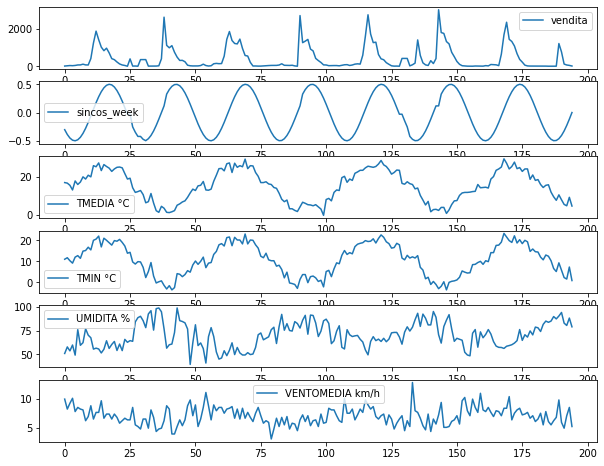

Turin data 



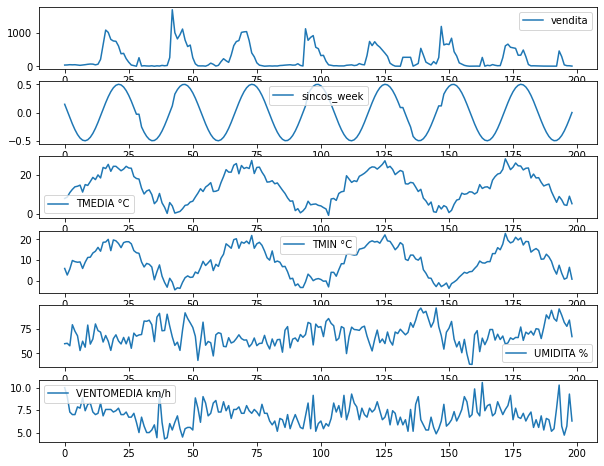

Rome data 



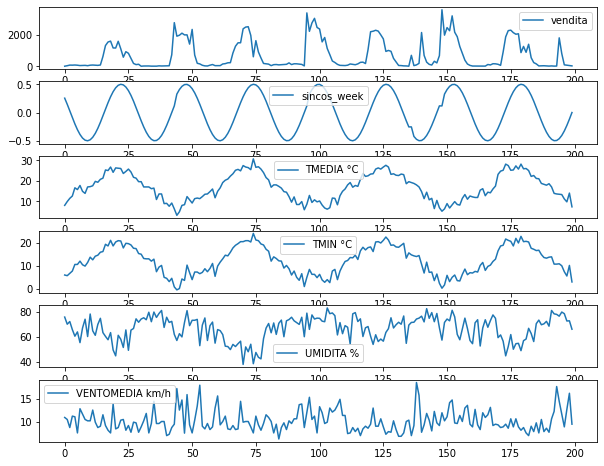

In [7]:
# Plot the data to explore and see what we are working with
for dataset in datasets:
    print(dataset, "data \n")
    # Plot the data with the most correlation to the sales we are trying to predict
    # These are the features we will train the network on later
    values = datasets[dataset].values
    cols_to_plot = [0,3,4,5,8,10]
    i=1
    plt.figure(figsize=(10,8))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(values[:, col], label=datasets[dataset].columns[col])
        plt.legend()
        i += 1
    plt.show()

# LSTM helper functions

In [8]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len=54, out_len=39):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")
    return inp_tr, out_tr, inp_te, out_te

def prepare_for_network(train, test, input_features, in_len, out_len):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [0,1]
    # We scale all our data in order to build the final training and test dataframes
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    
    for col in tr_df.columns:
        # Z standartization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std

    # Prepare data for the LSTM Network: We need to create sequences of inputs and outputs
    # so that our time series problem esentially becomes a "supervised regression problem".
    inp_tr, out_tr, inp_te, out_te = build_in_out_seq(tr_df, pd.concat([tr_df.iloc[-in_len:, :], te_df]), input_features, in_len, out_len)
    return inp_tr, out_tr, inp_te, out_te

def define_LSTM_Model(input_features):
    loss_fn = nn.MSELoss()
    LSTM_Model = Model(input_size=len(input_features), hidden_size=10+len(input_features)*5, output_size=len(input_features))
    optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
    opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)
    return LSTM_Model, opt_obj

def check_lstm_forecast_results(pred, inp_te, out_te, poll_mean, poll_std, in_len, out_len):
    # *Data back needs to rescaled back to normal*
    pred_vec = (pred[0,-out_len:,0].detach().cpu().numpy() * poll_std) + poll_mean
    real_vec = (out_te[0,:,0] * poll_std) + poll_mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    
    return rmse, mae

# Forecasting evaluation

In [9]:
single_run_results = []
n_runs = 5

for dataset in datasets:
    print("Running forecasting for sales in", dataset, "\n")
    for run in range(n_runs):
        print ("Run #", run+1)
        # Load the default and augmented versions of the data
        full_dataset = datasets[dataset]

        # Create training and test data
        train, test = ts_train_test_split(full_dataset)
      
        # Extract the columns which display most correlation with the value we are trying to predict.
        mono_input_features = [0]
        exo1_input_features = [0, 1, 2, 3]
        exo2_input_features = [0] + list(range(4,full_dataset.shape[1]))
        exo3_input_features = list(range(0,full_dataset.shape[1]))
        print("MONO-LSTM input features:", mono_input_features)
        print("EXO1 (+ sincos day) input features :", exo1_input_features)
        print("EXO2 (+ weather exog) input features :", exo2_input_features)
        print("EXO3 (+ all exog) input features :", exo3_input_features)
        print()
        
        ## Run STL Decomposition as baseline
        print("Running Drift and Seasonal Drift models based on STL Decomposition...")
        f_steps = test.shape[0]
        decomp = decompose(train.vendita, period=52)
        drift_forecast = forecast(decomp, steps=f_steps, fc_func=drift, seasonal=True)
        drift_rmse = sm.tools.eval_measures.rmse(test.vendita.values, drift_forecast["drift+seasonal"].values)
        drift_mae = sm.tools.eval_measures.meanabs(test.vendita.values, drift_forecast["drift+seasonal"].values)
        print("Done\n")
        
        # Run ARIMA as another baseline
        print("Running SARIMA model...")
        # Fit your model
        sarima_model = pm.auto_arima(train.vendita, seasonal=True, m=52, suppress_warnings=True, max_order=None, \
                                    start_p=3, start_q=0, start_P=0, start_Q=0, \
                                    max_p=6, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1)
        # Get model params
        sarima_order = sarima_model.get_params()["order"]
        sarima_s_order = sarima_model.get_params()["seasonal_order"]
        # Predict #test steps into the future
        sarima_forecasts = sarima_model.predict(f_steps)  
        sarima_rmse = sm.tools.eval_measures.rmse(test.vendita.values, sarima_forecasts)
        sarima_mae = sm.tools.eval_measures.meanabs(test.vendita.values, sarima_forecasts)
        print("Done\n")
        
        print("Running SARIMAX model...")
        sarimax_model = SARIMAX(endog=train.vendita, exog=train.iloc[:, exo3_input_features[1:]], \
                                order=sarima_order, seasonal_order=sarima_s_order)
        sarimax_fitted = sarimax_model.fit()
        sarimax_forecasts = sarimax_fitted.forecast(f_steps, exog=test.iloc[:, exo3_input_features[1:]])  
        sarimax_rmse = sm.tools.eval_measures.rmse(test.vendita.values, sarimax_forecasts)
        sarimax_mae = sm.tools.eval_measures.meanabs(test.vendita.values, sarimax_forecasts)
        print("Done\n")
        
        ## LSTM
        # Define the LSTM Models and their Optimizer objects
        mono_LSTM_Model, mono_opt_obj = define_LSTM_Model(mono_input_features)
        exo1_LSTM_Model, exo1_opt_obj = define_LSTM_Model(exo1_input_features)
        exo2_LSTM_Model, exo2_opt_obj = define_LSTM_Model(exo2_input_features)
        exo3_LSTM_Model, exo3_opt_obj = define_LSTM_Model(exo3_input_features)

        # 1) MONO-LSTM data
        mono_inp_tr, mono_out_tr, mono_inp_te, mono_out_te = prepare_for_network(train, test, mono_input_features, in_len=54, out_len=f_steps)
        mono_x_train=torch.cat((torch.Tensor(mono_inp_tr),torch.Tensor(mono_out_tr)),1)
        mono_x_test=torch.Tensor(mono_inp_te)

        # 2) EXO1-LSTM data
        exo1_inp_tr, exo1_out_tr, exo1_inp_te, exo1_out_te = prepare_for_network(train, test, exo1_input_features, in_len=54, out_len=f_steps)
        exo1_x_train=torch.cat((torch.Tensor(exo1_inp_tr),torch.Tensor(exo1_out_tr)),1)
        exo1_x_test=torch.Tensor(exo1_inp_te)

        # 3) EXO2-LSTM data
        exo2_inp_tr, exo2_out_tr, exo2_inp_te, exo2_out_te = prepare_for_network(train, test, exo2_input_features, in_len=54, out_len=f_steps)
        exo2_x_train=torch.cat((torch.Tensor(exo2_inp_tr),torch.Tensor(exo2_out_tr)),1)
        exo2_x_test=torch.Tensor(exo2_inp_te)

        # 4) EXO3-LSTM data
        exo3_inp_tr, exo3_out_tr, exo3_inp_te, exo3_out_te = prepare_for_network(train, test, exo3_input_features, in_len=54, out_len=f_steps)
        exo3_x_train=torch.cat((torch.Tensor(exo3_inp_tr),torch.Tensor(exo3_out_tr)),1)
        exo3_x_test=torch.Tensor(exo3_inp_te)

        # Train all the LSTMs 
        print("Training the MONO-LSTM model...")
        mono_opt_obj.train(mono_x_train[:,:-1],mono_x_train[:,1:],mono_x_train[:,:-1],mono_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=15+len(mono_input_features)*3, batch_size=8)
        print("Done\n")
        print("Training the EXO1-LSTM model...")
        exo1_opt_obj.train(exo1_x_train[:,:-1],exo1_x_train[:,1:],exo1_x_train[:,:-1],exo1_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=15+len(exo1_input_features)*3, batch_size=8)
        print("Done\n")
        print("Training the EXO2-LSTM model...")
        exo2_opt_obj.train(exo2_x_train[:,:-1],exo2_x_train[:,1:],exo2_x_train[:,:-1],exo2_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=15+len(exo2_input_features)*3, batch_size=8)
        print("Done\n")
        print("Training the EXO3-LSTM model...")
        exo3_opt_obj.train(exo3_x_train[:,:-1],exo3_x_train[:,1:],exo3_x_train[:,:-1],exo3_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=15+len(exo3_input_features)*3, batch_size=8)
        print("Done\n")

        # Make predictions using the trained networks
        mono_pred = mono_LSTM_Model(mono_x_test, f_steps)
        exo1_pred = exo1_LSTM_Model(exo1_x_test, f_steps)
        exo2_pred = exo2_LSTM_Model(exo2_x_test, f_steps)
        exo3_pred = exo3_LSTM_Model(exo3_x_test, f_steps)

        ## Check results of LSTM forecasts (calc erros)
        mean = np.mean(train.vendita.values)
        std = np.std(train.vendita.values)
        mono_lstm_rmse, mono_lstm_mae = check_lstm_forecast_results(mono_pred, mono_inp_te, mono_out_te, mean, std, in_len=54, out_len=f_steps)
        exo1_lstm_rmse, exo1_lstm_mae = check_lstm_forecast_results(exo1_pred, exo1_inp_te, exo1_out_te, mean, std, in_len=54, out_len=f_steps)
        exo2_lstm_rmse, exo2_lstm_mae = check_lstm_forecast_results(exo2_pred, exo2_inp_te, exo2_out_te, mean, std, in_len=54, out_len=f_steps)
        exo3_lstm_rmse, exo3_lstm_mae = check_lstm_forecast_results(exo3_pred, exo3_inp_te, exo3_out_te, mean, std, in_len=54, out_len=f_steps)

        fig = go.Figure()
        x_labels = list(range(0,f_steps))
        fig.add_trace(go.Scatter(x=x_labels, y=test.vendita,
                    mode='lines', name='GT'))
        fig.add_trace(go.Scatter(x=x_labels, y=drift_forecast["drift+seasonal"].values,
                    mode='lines', name='SDRIFT'))
        fig.add_trace(go.Scatter(x=x_labels, y=sarima_forecasts,
                    mode='lines', name='SARIMA'+str(sarima_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=sarimax_forecasts,
                    mode='lines', name='SARIMAX'+str(sarima_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=(mono_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='MONO-LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(exo1_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='EXO1-LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(exo2_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='EXO2-LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(exo3_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name='EXO3-LSTM'))
        #Update plot title and axis titles, then save plot as a HTML File
        fig.update_layout(
            title="Forecast of test set",
            xaxis_title="Time steps",
            yaxis_title="Prediction",
            font=dict(
                family="Courier New, monospace",
                size=16,
                color="#7f7f7f"
            )
        )
        fig.show()
        pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"weekly-sales-results.html")
 
        single_run_results.append([dataset, "run "+str(run+1), drift_rmse, sarima_rmse, sarimax_rmse, mono_lstm_rmse, \
                                   exo1_lstm_rmse, exo2_lstm_rmse, exo3_lstm_rmse, drift_mae, sarima_mae, sarimax_mae, \
                                   mono_lstm_mae, exo1_lstm_mae, exo2_lstm_mae, exo3_lstm_mae])
    
        print()

Running forecasting for sales in Milan 

Run # 1
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (1, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (1, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Done

Inputs for training
(64, 54, 1)
Outputs for training
(64, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(64, 54, 4)
Outputs for training
(64, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(64, 54, 11)
Outputs for training
(64, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(64, 54, 14)
Outputs for training
(64, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.08. Validation loss: 1.06. Avg future: 22.86. Elapsed time: 0.38s.
Epoch 2 Train loss: 1.05. Validation loss: 1.03. Avg future: 19.86. Elapsed time: 0.36s.
Epoch 3 Train loss: 1.03. Validation loss: 1.01. Avg future: 29.43. Elapsed time: 0.38s.
Epoch 4 Train loss: 1.01. Validation loss: 0.98. Avg future: 26.43. Elapsed time: 0.41s.
Epoch 5 Train loss: 0.98. Validation loss: 0.96. Avg future: 18.00. Elapsed time: 0.38

Epoch 41 Train loss: 0.34. Validation loss: 0.35. Avg future: 35.71. Elapsed time: 0.54s.
Epoch 42 Train loss: 0.34. Validation loss: 0.35. Avg future: 25.14. Elapsed time: 0.53s.
Epoch 43 Train loss: 0.34. Validation loss: 0.35. Avg future: 26.43. Elapsed time: 0.52s.
Epoch 44 Train loss: 0.34. Validation loss: 0.35. Avg future: 31.00. Elapsed time: 0.54s.
Epoch 45 Train loss: 0.34. Validation loss: 0.35. Avg future: 17.86. Elapsed time: 0.54s.
Epoch 46 Train loss: 0.34. Validation loss: 0.35. Avg future: 20.43. Elapsed time: 0.54s.
Epoch 47 Train loss: 0.34. Validation loss: 0.34. Avg future: 14.00. Elapsed time: 0.50s.
Epoch 48 Train loss: 0.34. Validation loss: 0.34. Avg future: 28.29. Elapsed time: 0.55s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.06. Validation loss: 0.98. Avg future: 32.57. Elapsed time: 0.64s.
Epoch 2 Train loss: 0.93. Validation loss: 0.83. Avg future: 27.14. Elapsed time: 0.60s.
Epoch 3 Train loss: 0.77. Validation loss: 0.67. Avg future: 24.


Run # 2
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")



Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(64, 54, 1)
Outputs for training
(64, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(64, 54, 4)
Outputs for training
(64, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(64, 54, 11)
Outputs for training
(64, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(64, 54, 14)
Outputs for training
(64, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.09. Validation loss: 1.07. Avg future: 23.71. Elapsed time: 0.36s.
Epoch 2 Train loss: 1.06. Validation loss: 1.05. Avg future: 17.00. Elapsed time: 0.36s.
Epoch 3 Train loss: 1.05. Validation loss: 1.03. Avg future: 23.86. Elapsed time: 0.36s.
Epoch 4 Train loss: 1.02. Validation loss: 1.01. Avg future: 20.86. Elapsed time: 0.36s.
Epoch 5 Train loss: 1.00. Validation loss: 0.99. Avg future: 20.57. Elapsed time: 0.36

Epoch 41 Train loss: 0.32. Validation loss: 0.33. Avg future: 29.29. Elapsed time: 0.55s.
Epoch 42 Train loss: 0.32. Validation loss: 0.33. Avg future: 33.00. Elapsed time: 0.56s.
Epoch 43 Train loss: 0.33. Validation loss: 0.33. Avg future: 12.14. Elapsed time: 0.51s.
Epoch 44 Train loss: 0.32. Validation loss: 0.33. Avg future: 20.14. Elapsed time: 0.50s.
Epoch 45 Train loss: 0.32. Validation loss: 0.33. Avg future: 32.29. Elapsed time: 0.51s.
Epoch 46 Train loss: 0.32. Validation loss: 0.33. Avg future: 33.43. Elapsed time: 0.53s.
Epoch 47 Train loss: 0.32. Validation loss: 0.33. Avg future: 23.43. Elapsed time: 0.51s.
Epoch 48 Train loss: 0.32. Validation loss: 0.32. Avg future: 16.86. Elapsed time: 0.52s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.03. Validation loss: 0.95. Avg future: 20.29. Elapsed time: 0.55s.
Epoch 2 Train loss: 0.90. Validation loss: 0.79. Avg future: 16.43. Elapsed time: 0.55s.
Epoch 3 Train loss: 0.75. Validation loss: 0.63. Avg future: 24.


Run # 3
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")



Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(64, 54, 1)
Outputs for training
(64, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(64, 54, 4)
Outputs for training
(64, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(64, 54, 11)
Outputs for training
(64, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(64, 54, 14)
Outputs for training
(64, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.04. Validation loss: 1.03. Avg future: 24.86. Elapsed time: 0.36s.
Epoch 2 Train loss: 1.03. Validation loss: 1.01. Avg future: 20.14. Elapsed time: 0.36s.
Epoch 3 Train loss: 1.00. Validation loss: 1.00. Avg future: 17.71. Elapsed time: 0.35s.
Epoch 4 Train loss: 0.99. Validation loss: 0.98. Avg future: 19.14. Elapsed time: 0.36s.
Epoch 5 Train loss: 0.98. Validation loss: 0.96. Avg future: 20.86. Elapsed time: 0.36

Epoch 41 Train loss: 0.32. Validation loss: 0.32. Avg future: 22.00. Elapsed time: 1.09s.
Epoch 42 Train loss: 0.32. Validation loss: 0.32. Avg future: 10.57. Elapsed time: 1.11s.
Epoch 43 Train loss: 0.32. Validation loss: 0.32. Avg future: 21.00. Elapsed time: 0.92s.
Epoch 44 Train loss: 0.31. Validation loss: 0.32. Avg future: 23.57. Elapsed time: 0.82s.
Epoch 45 Train loss: 0.31. Validation loss: 0.32. Avg future: 23.71. Elapsed time: 2.16s.
Epoch 46 Train loss: 0.31. Validation loss: 0.32. Avg future: 21.29. Elapsed time: 1.30s.
Epoch 47 Train loss: 0.31. Validation loss: 0.32. Avg future: 23.43. Elapsed time: 2.64s.
Epoch 48 Train loss: 0.31. Validation loss: 0.32. Avg future: 20.00. Elapsed time: 1.68s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.04. Validation loss: 0.96. Avg future: 32.86. Elapsed time: 2.13s.
Epoch 2 Train loss: 0.93. Validation loss: 0.83. Avg future: 30.00. Elapsed time: 2.78s.
Epoch 3 Train loss: 0.78. Validation loss: 0.67. Avg future: 28.


Run # 4
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")



Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(64, 54, 1)
Outputs for training
(64, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(64, 54, 4)
Outputs for training
(64, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(64, 54, 11)
Outputs for training
(64, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(64, 54, 14)
Outputs for training
(64, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.22. Validation loss: 1.22. Avg future: 23.00. Elapsed time: 0.72s.
Epoch 2 Train loss: 1.20. Validation loss: 1.19. Avg future: 30.43. Elapsed time: 0.59s.
Epoch 3 Train loss: 1.18. Validation loss: 1.17. Avg future: 24.57. Elapsed time: 0.62s.
Epoch 4 Train loss: 1.16. Validation loss: 1.15. Avg future: 18.29. Elapsed time: 0.79s.
Epoch 5 Train loss: 1.14. Validation loss: 1.12. Avg future: 21.14. Elapsed time: 0.92

Epoch 41 Train loss: 0.32. Validation loss: 0.33. Avg future: 16.43. Elapsed time: 1.27s.
Epoch 42 Train loss: 0.32. Validation loss: 0.32. Avg future: 13.43. Elapsed time: 1.13s.
Epoch 43 Train loss: 0.32. Validation loss: 0.32. Avg future: 35.43. Elapsed time: 1.07s.
Epoch 44 Train loss: 0.32. Validation loss: 0.32. Avg future: 10.57. Elapsed time: 1.13s.
Epoch 45 Train loss: 0.32. Validation loss: 0.32. Avg future: 24.86. Elapsed time: 1.08s.
Epoch 46 Train loss: 0.32. Validation loss: 0.32. Avg future: 24.29. Elapsed time: 1.19s.
Epoch 47 Train loss: 0.31. Validation loss: 0.32. Avg future: 34.86. Elapsed time: 1.23s.
Epoch 48 Train loss: 0.31. Validation loss: 0.32. Avg future: 31.29. Elapsed time: 1.17s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.07. Validation loss: 1.00. Avg future: 25.29. Elapsed time: 1.16s.
Epoch 2 Train loss: 0.96. Validation loss: 0.87. Avg future: 25.86. Elapsed time: 1.08s.
Epoch 3 Train loss: 0.82. Validation loss: 0.71. Avg future: 21.


Run # 5
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (0, 0, 1)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(1, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning:

Unable to fit ARIMA for (1, 0, 0)x(0, 0, 1, 52); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")



Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(64, 54, 1)
Outputs for training
(64, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(64, 54, 4)
Outputs for training
(64, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(64, 54, 11)
Outputs for training
(64, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(64, 54, 14)
Outputs for training
(64, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.17. Validation loss: 1.16. Avg future: 18.43. Elapsed time: 0.67s.
Epoch 2 Train loss: 1.15. Validation loss: 1.14. Avg future: 25.00. Elapsed time: 0.64s.
Epoch 3 Train loss: 1.13. Validation loss: 1.11. Avg future: 28.14. Elapsed time: 0.69s.
Epoch 4 Train loss: 1.11. Validation loss: 1.09. Avg future: 12.86. Elapsed time: 0.66s.
Epoch 5 Train loss: 1.08. Validation loss: 1.07. Avg future: 20.57. Elapsed time: 0.62

Epoch 41 Train loss: 0.31. Validation loss: 0.31. Avg future: 20.14. Elapsed time: 1.25s.
Epoch 42 Train loss: 0.30. Validation loss: 0.31. Avg future: 23.43. Elapsed time: 1.32s.
Epoch 43 Train loss: 0.30. Validation loss: 0.31. Avg future: 25.57. Elapsed time: 1.11s.
Epoch 44 Train loss: 0.31. Validation loss: 0.31. Avg future: 20.43. Elapsed time: 1.07s.
Epoch 45 Train loss: 0.30. Validation loss: 0.31. Avg future: 28.00. Elapsed time: 1.10s.
Epoch 46 Train loss: 0.30. Validation loss: 0.31. Avg future: 28.14. Elapsed time: 1.15s.
Epoch 47 Train loss: 0.30. Validation loss: 0.31. Avg future: 25.86. Elapsed time: 1.14s.
Epoch 48 Train loss: 0.30. Validation loss: 0.31. Avg future: 22.14. Elapsed time: 1.18s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.06. Validation loss: 0.99. Avg future: 18.71. Elapsed time: 1.07s.
Epoch 2 Train loss: 0.95. Validation loss: 0.84. Avg future: 30.57. Elapsed time: 1.09s.
Epoch 3 Train loss: 0.78. Validation loss: 0.65. Avg future: 27.


Running forecasting for sales in Turin 

Run # 1
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(68, 54, 1)
Outputs for training
(68, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(68, 54, 4)
Outputs for training
(68, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(68, 54, 11)
Outputs for training
(68, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(68, 54, 14)
Outputs for training
(68, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.21. Validation loss: 1.18. Avg future: 19.88. Elapsed time: 0.78s.
Epoch 2 Train loss: 1.16. Validation loss: 1.13. Avg future: 15.50. Elapsed time: 0.73s.
Epoch 3 Train loss: 1.13. Validation loss: 1.09. Avg future: 31.62. Elapsed time: 0.77s.
Epoch 4 Train loss: 1.08. Validation loss: 1.05. Avg future: 23.62. Elapsed time: 1.22s.
Epoch 5 Train loss: 1.04. Validation loss: 1.00. Avg future: 20.62. Elapsed time: 0.73

Epoch 41 Train loss: 0.35. Validation loss: 0.35. Avg future: 24.38. Elapsed time: 1.30s.
Epoch 42 Train loss: 0.35. Validation loss: 0.35. Avg future: 20.25. Elapsed time: 1.20s.
Epoch 43 Train loss: 0.35. Validation loss: 0.35. Avg future: 29.25. Elapsed time: 1.30s.
Epoch 44 Train loss: 0.35. Validation loss: 0.35. Avg future: 21.25. Elapsed time: 1.44s.
Epoch 45 Train loss: 0.35. Validation loss: 0.35. Avg future: 12.50. Elapsed time: 1.20s.
Epoch 46 Train loss: 0.35. Validation loss: 0.35. Avg future: 31.25. Elapsed time: 2.31s.
Epoch 47 Train loss: 0.35. Validation loss: 0.35. Avg future: 20.25. Elapsed time: 1.59s.
Epoch 48 Train loss: 0.35. Validation loss: 0.35. Avg future: 26.00. Elapsed time: 1.24s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.08. Validation loss: 1.00. Avg future: 25.62. Elapsed time: 1.46s.
Epoch 2 Train loss: 0.95. Validation loss: 0.83. Avg future: 21.62. Elapsed time: 1.31s.
Epoch 3 Train loss: 0.77. Validation loss: 0.66. Avg future: 25.


Run # 2
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(68, 54, 1)
Outputs for training
(68, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(68, 54, 4)
Outputs for training
(68, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(68, 54, 11)
Outputs for training
(68, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(68, 54, 14)
Outputs for training
(68, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.26. Validation loss: 1.22. Avg future: 21.88. Elapsed time: 0.79s.
Epoch 2 Train loss: 1.21. Validation loss: 1.18. Avg future: 21.62. Elapsed time: 0.90s.
Epoch 3 Train loss: 1.16. Validation loss: 1.13. Avg future: 23.88. Elapsed time: 0.70s.
Epoch 4 Train loss: 1.12. Validation loss: 1.09. Avg future: 18.50. Elapsed time: 0.84s.
Epoch 5 Train loss: 1.08. Validation loss: 1.06. Avg future: 19.12. Elapsed time: 0.82

Epoch 41 Train loss: 0.35. Validation loss: 0.35. Avg future: 22.00. Elapsed time: 1.34s.
Epoch 42 Train loss: 0.35. Validation loss: 0.35. Avg future: 19.25. Elapsed time: 1.30s.
Epoch 43 Train loss: 0.35. Validation loss: 0.35. Avg future: 23.38. Elapsed time: 1.33s.
Epoch 44 Train loss: 0.34. Validation loss: 0.34. Avg future: 16.12. Elapsed time: 1.31s.
Epoch 45 Train loss: 0.34. Validation loss: 0.34. Avg future: 19.88. Elapsed time: 1.54s.
Epoch 46 Train loss: 0.34. Validation loss: 0.34. Avg future: 30.75. Elapsed time: 1.32s.
Epoch 47 Train loss: 0.34. Validation loss: 0.34. Avg future: 16.12. Elapsed time: 1.28s.
Epoch 48 Train loss: 0.34. Validation loss: 0.34. Avg future: 26.88. Elapsed time: 1.29s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.08. Validation loss: 0.99. Avg future: 35.50. Elapsed time: 1.26s.
Epoch 2 Train loss: 0.94. Validation loss: 0.82. Avg future: 29.50. Elapsed time: 1.39s.
Epoch 3 Train loss: 0.76. Validation loss: 0.66. Avg future: 16.


Run # 3
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(68, 54, 1)
Outputs for training
(68, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(68, 54, 4)
Outputs for training
(68, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(68, 54, 11)
Outputs for training
(68, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(68, 54, 14)
Outputs for training
(68, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.27. Validation loss: 1.24. Avg future: 30.12. Elapsed time: 0.76s.
Epoch 2 Train loss: 1.23. Validation loss: 1.21. Avg future: 19.38. Elapsed time: 0.69s.
Epoch 3 Train loss: 1.20. Validation loss: 1.17. Avg future: 24.38. Elapsed time: 0.70s.
Epoch 4 Train loss: 1.16. Validation loss: 1.14. Avg future: 23.75. Elapsed time: 0.77s.
Epoch 5 Train loss: 1.14. Validation loss: 1.11. Avg future: 26.12. Elapsed time: 1.25

Epoch 41 Train loss: 0.36. Validation loss: 0.36. Avg future: 28.75. Elapsed time: 1.22s.
Epoch 42 Train loss: 0.36. Validation loss: 0.36. Avg future: 22.75. Elapsed time: 1.21s.
Epoch 43 Train loss: 0.36. Validation loss: 0.36. Avg future: 20.62. Elapsed time: 1.33s.
Epoch 44 Train loss: 0.36. Validation loss: 0.36. Avg future: 15.25. Elapsed time: 1.30s.
Epoch 45 Train loss: 0.35. Validation loss: 0.36. Avg future: 29.50. Elapsed time: 1.40s.
Epoch 46 Train loss: 0.36. Validation loss: 0.36. Avg future: 24.50. Elapsed time: 1.36s.
Epoch 47 Train loss: 0.35. Validation loss: 0.36. Avg future: 24.00. Elapsed time: 1.40s.
Epoch 48 Train loss: 0.35. Validation loss: 0.36. Avg future: 24.38. Elapsed time: 1.34s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.06. Validation loss: 0.98. Avg future: 26.62. Elapsed time: 2.25s.
Epoch 2 Train loss: 0.93. Validation loss: 0.81. Avg future: 25.00. Elapsed time: 2.11s.
Epoch 3 Train loss: 0.74. Validation loss: 0.63. Avg future: 23.


Run # 4
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(68, 54, 1)
Outputs for training
(68, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(68, 54, 4)
Outputs for training
(68, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(68, 54, 11)
Outputs for training
(68, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(68, 54, 14)
Outputs for training
(68, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.13. Validation loss: 1.10. Avg future: 29.00. Elapsed time: 0.86s.
Epoch 2 Train loss: 1.09. Validation loss: 1.06. Avg future: 27.00. Elapsed time: 0.99s.
Epoch 3 Train loss: 1.06. Validation loss: 1.03. Avg future: 29.62. Elapsed time: 0.78s.
Epoch 4 Train loss: 1.01. Validation loss: 0.99. Avg future: 17.38. Elapsed time: 0.73s.
Epoch 5 Train loss: 0.99. Validation loss: 0.95. Avg future: 33.00. Elapsed time: 0.78

Epoch 41 Train loss: 0.35. Validation loss: 0.35. Avg future: 28.38. Elapsed time: 3.73s.
Epoch 42 Train loss: 0.35. Validation loss: 0.35. Avg future: 24.75. Elapsed time: 3.17s.
Epoch 43 Train loss: 0.35. Validation loss: 0.35. Avg future: 18.50. Elapsed time: 2.09s.
Epoch 44 Train loss: 0.35. Validation loss: 0.35. Avg future: 19.88. Elapsed time: 6.62s.
Epoch 45 Train loss: 0.35. Validation loss: 0.35. Avg future: 25.88. Elapsed time: 1.86s.
Epoch 46 Train loss: 0.35. Validation loss: 0.35. Avg future: 24.62. Elapsed time: 3.14s.
Epoch 47 Train loss: 0.35. Validation loss: 0.35. Avg future: 23.12. Elapsed time: 1.57s.
Epoch 48 Train loss: 0.35. Validation loss: 0.35. Avg future: 19.00. Elapsed time: 1.65s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.06. Validation loss: 0.98. Avg future: 34.75. Elapsed time: 3.51s.
Epoch 2 Train loss: 0.93. Validation loss: 0.81. Avg future: 25.25. Elapsed time: 1.93s.
Epoch 3 Train loss: 0.75. Validation loss: 0.64. Avg future: 23.


Run # 5
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(68, 54, 1)
Outputs for training
(68, 39, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 39, 1)


Inputs for training
(68, 54, 4)
Outputs for training
(68, 39, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 39, 4)


Inputs for training
(68, 54, 11)
Outputs for training
(68, 39, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 39, 11)


Inputs for training
(68, 54, 14)
Outputs for training
(68, 39, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 39, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.22. Validation loss: 1.20. Avg future: 23.25. Elapsed time: 0.91s.
Epoch 2 Train loss: 1.19. Validation loss: 1.17. Avg future: 22.75. Elapsed time: 0.85s.
Epoch 3 Train loss: 1.16. Validation loss: 1.14. Avg future: 20.38. Elapsed time: 0.79s.
Epoch 4 Train loss: 1.13. Validation loss: 1.11. Avg future: 26.75. Elapsed time: 0.88s.
Epoch 5 Train loss: 1.10. Validation loss: 1.08. Avg future: 14.25. Elapsed time: 1.03

Epoch 41 Train loss: 0.36. Validation loss: 0.36. Avg future: 21.75. Elapsed time: 1.95s.
Epoch 42 Train loss: 0.36. Validation loss: 0.36. Avg future: 25.88. Elapsed time: 1.28s.
Epoch 43 Train loss: 0.36. Validation loss: 0.36. Avg future: 22.00. Elapsed time: 1.92s.
Epoch 44 Train loss: 0.36. Validation loss: 0.36. Avg future: 21.62. Elapsed time: 2.28s.
Epoch 45 Train loss: 0.36. Validation loss: 0.36. Avg future: 26.25. Elapsed time: 2.99s.
Epoch 46 Train loss: 0.35. Validation loss: 0.36. Avg future: 25.00. Elapsed time: 2.85s.
Epoch 47 Train loss: 0.36. Validation loss: 0.35. Avg future: 18.62. Elapsed time: 1.04s.
Epoch 48 Train loss: 0.35. Validation loss: 0.35. Avg future: 25.62. Elapsed time: 1.49s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.08. Validation loss: 0.99. Avg future: 22.88. Elapsed time: 0.78s.
Epoch 2 Train loss: 0.94. Validation loss: 0.82. Avg future: 24.38. Elapsed time: 1.24s.
Epoch 3 Train loss: 0.76. Validation loss: 0.64. Avg future: 32.


Running forecasting for sales in Rome 

Run # 1
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(67, 54, 1)
Outputs for training
(67, 40, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 40, 1)


Inputs for training
(67, 54, 4)
Outputs for training
(67, 40, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 40, 4)


Inputs for training
(67, 54, 11)
Outputs for training
(67, 40, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 40, 11)


Inputs for training
(67, 54, 14)
Outputs for training
(67, 40, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 40, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.13. Validation loss: 1.10. Avg future: 26.25. Elapsed time: 0.68s.
Epoch 2 Train loss: 1.09. Validation loss: 1.06. Avg future: 29.50. Elapsed time: 0.46s.
Epoch 3 Train loss: 1.05. Validation loss: 1.02. Avg future: 23.00. Elapsed time: 0.50s.
Epoch 4 Train loss: 1.02. Validation loss: 0.98. Avg future: 26.75. Elapsed time: 0.46s.
Epoch 5 Train loss: 0.97. Validation loss: 0.93. Avg future: 24.12. Elapsed time: 0.41

Epoch 41 Train loss: 0.29. Validation loss: 0.29. Avg future: 20.25. Elapsed time: 0.69s.
Epoch 42 Train loss: 0.29. Validation loss: 0.29. Avg future: 22.38. Elapsed time: 0.67s.
Epoch 43 Train loss: 0.29. Validation loss: 0.29. Avg future: 22.00. Elapsed time: 0.59s.
Epoch 44 Train loss: 0.29. Validation loss: 0.29. Avg future: 24.62. Elapsed time: 0.65s.
Epoch 45 Train loss: 0.28. Validation loss: 0.29. Avg future: 22.25. Elapsed time: 0.64s.
Epoch 46 Train loss: 0.28. Validation loss: 0.29. Avg future: 26.50. Elapsed time: 0.63s.
Epoch 47 Train loss: 0.28. Validation loss: 0.29. Avg future: 16.00. Elapsed time: 0.65s.
Epoch 48 Train loss: 0.28. Validation loss: 0.29. Avg future: 29.88. Elapsed time: 0.65s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.06. Validation loss: 0.97. Avg future: 23.00. Elapsed time: 0.67s.
Epoch 2 Train loss: 0.91. Validation loss: 0.80. Avg future: 19.12. Elapsed time: 0.64s.
Epoch 3 Train loss: 0.75. Validation loss: 0.65. Avg future: 22.


Run # 2
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(67, 54, 1)
Outputs for training
(67, 40, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 40, 1)


Inputs for training
(67, 54, 4)
Outputs for training
(67, 40, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 40, 4)


Inputs for training
(67, 54, 11)
Outputs for training
(67, 40, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 40, 11)


Inputs for training
(67, 54, 14)
Outputs for training
(67, 40, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 40, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.10. Validation loss: 1.06. Avg future: 17.88. Elapsed time: 0.41s.
Epoch 2 Train loss: 1.05. Validation loss: 1.01. Avg future: 22.12. Elapsed time: 0.42s.
Epoch 3 Train loss: 1.01. Validation loss: 0.97. Avg future: 26.25. Elapsed time: 0.47s.
Epoch 4 Train loss: 0.97. Validation loss: 0.93. Avg future: 24.50. Elapsed time: 0.44s.
Epoch 5 Train loss: 0.93. Validation loss: 0.89. Avg future: 26.38. Elapsed time: 0.46

Epoch 41 Train loss: 0.29. Validation loss: 0.30. Avg future: 20.12. Elapsed time: 0.59s.
Epoch 42 Train loss: 0.29. Validation loss: 0.29. Avg future: 24.62. Elapsed time: 0.59s.
Epoch 43 Train loss: 0.29. Validation loss: 0.29. Avg future: 18.88. Elapsed time: 0.65s.
Epoch 44 Train loss: 0.29. Validation loss: 0.29. Avg future: 22.25. Elapsed time: 0.69s.
Epoch 45 Train loss: 0.29. Validation loss: 0.29. Avg future: 21.75. Elapsed time: 0.70s.
Epoch 46 Train loss: 0.29. Validation loss: 0.29. Avg future: 26.25. Elapsed time: 0.73s.
Epoch 47 Train loss: 0.29. Validation loss: 0.29. Avg future: 17.50. Elapsed time: 0.62s.
Epoch 48 Train loss: 0.29. Validation loss: 0.29. Avg future: 28.75. Elapsed time: 0.62s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.07. Validation loss: 0.99. Avg future: 26.88. Elapsed time: 0.73s.
Epoch 2 Train loss: 0.94. Validation loss: 0.84. Avg future: 20.62. Elapsed time: 0.66s.
Epoch 3 Train loss: 0.78. Validation loss: 0.67. Avg future: 25.


Run # 3
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(67, 54, 1)
Outputs for training
(67, 40, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 40, 1)


Inputs for training
(67, 54, 4)
Outputs for training
(67, 40, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 40, 4)


Inputs for training
(67, 54, 11)
Outputs for training
(67, 40, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 40, 11)


Inputs for training
(67, 54, 14)
Outputs for training
(67, 40, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 40, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.21. Validation loss: 1.19. Avg future: 20.88. Elapsed time: 0.44s.
Epoch 2 Train loss: 1.18. Validation loss: 1.16. Avg future: 24.12. Elapsed time: 0.44s.
Epoch 3 Train loss: 1.15. Validation loss: 1.13. Avg future: 24.62. Elapsed time: 0.46s.
Epoch 4 Train loss: 1.12. Validation loss: 1.10. Avg future: 21.25. Elapsed time: 0.42s.
Epoch 5 Train loss: 1.08. Validation loss: 1.06. Avg future: 14.50. Elapsed time: 0.46

Epoch 41 Train loss: 0.31. Validation loss: 0.31. Avg future: 17.00. Elapsed time: 0.70s.
Epoch 42 Train loss: 0.30. Validation loss: 0.31. Avg future: 19.25. Elapsed time: 0.63s.
Epoch 43 Train loss: 0.30. Validation loss: 0.31. Avg future: 23.50. Elapsed time: 0.64s.
Epoch 44 Train loss: 0.30. Validation loss: 0.31. Avg future: 35.50. Elapsed time: 0.81s.
Epoch 45 Train loss: 0.30. Validation loss: 0.31. Avg future: 25.88. Elapsed time: 0.64s.
Epoch 46 Train loss: 0.30. Validation loss: 0.31. Avg future: 26.00. Elapsed time: 0.65s.
Epoch 47 Train loss: 0.30. Validation loss: 0.30. Avg future: 18.00. Elapsed time: 0.65s.
Epoch 48 Train loss: 0.30. Validation loss: 0.30. Avg future: 24.62. Elapsed time: 0.64s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.08. Validation loss: 1.00. Avg future: 24.38. Elapsed time: 0.63s.
Epoch 2 Train loss: 0.94. Validation loss: 0.85. Avg future: 18.50. Elapsed time: 0.63s.
Epoch 3 Train loss: 0.80. Validation loss: 0.70. Avg future: 30.


Run # 4
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(67, 54, 1)
Outputs for training
(67, 40, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 40, 1)


Inputs for training
(67, 54, 4)
Outputs for training
(67, 40, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 40, 4)


Inputs for training
(67, 54, 11)
Outputs for training
(67, 40, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 40, 11)


Inputs for training
(67, 54, 14)
Outputs for training
(67, 40, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 40, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.33. Validation loss: 1.31. Avg future: 24.88. Elapsed time: 0.43s.
Epoch 2 Train loss: 1.29. Validation loss: 1.28. Avg future: 22.12. Elapsed time: 0.42s.
Epoch 3 Train loss: 1.25. Validation loss: 1.24. Avg future: 27.00. Elapsed time: 0.43s.
Epoch 4 Train loss: 1.22. Validation loss: 1.21. Avg future: 23.38. Elapsed time: 0.43s.
Epoch 5 Train loss: 1.19. Validation loss: 1.18. Avg future: 9.75. Elapsed time: 0.41s

Epoch 41 Train loss: 0.30. Validation loss: 0.31. Avg future: 30.38. Elapsed time: 0.65s.
Epoch 42 Train loss: 0.30. Validation loss: 0.31. Avg future: 24.75. Elapsed time: 0.60s.
Epoch 43 Train loss: 0.30. Validation loss: 0.31. Avg future: 20.75. Elapsed time: 0.60s.
Epoch 44 Train loss: 0.30. Validation loss: 0.30. Avg future: 21.12. Elapsed time: 0.63s.
Epoch 45 Train loss: 0.30. Validation loss: 0.30. Avg future: 28.62. Elapsed time: 0.61s.
Epoch 46 Train loss: 0.30. Validation loss: 0.30. Avg future: 22.12. Elapsed time: 0.62s.
Epoch 47 Train loss: 0.30. Validation loss: 0.30. Avg future: 21.88. Elapsed time: 0.62s.
Epoch 48 Train loss: 0.30. Validation loss: 0.30. Avg future: 27.50. Elapsed time: 0.62s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.07. Validation loss: 0.99. Avg future: 23.00. Elapsed time: 0.63s.
Epoch 2 Train loss: 0.94. Validation loss: 0.83. Avg future: 22.75. Elapsed time: 0.62s.
Epoch 3 Train loss: 0.78. Validation loss: 0.69. Avg future: 17.


Run # 5
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift and Seasonal Drift models based on STL Decomposition...
Done

Running SARIMA model...
Done

Running SARIMAX model...


/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Done

Inputs for training
(67, 54, 1)
Outputs for training
(67, 40, 1)
Inputs for testing
(1, 54, 1)
Outputs for testing
(1, 40, 1)


Inputs for training
(67, 54, 4)
Outputs for training
(67, 40, 4)
Inputs for testing
(1, 54, 4)
Outputs for testing
(1, 40, 4)


Inputs for training
(67, 54, 11)
Outputs for training
(67, 40, 11)
Inputs for testing
(1, 54, 11)
Outputs for testing
(1, 40, 11)


Inputs for training
(67, 54, 14)
Outputs for training
(67, 40, 14)
Inputs for testing
(1, 54, 14)
Outputs for testing
(1, 40, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.17. Validation loss: 1.15. Avg future: 25.25. Elapsed time: 0.53s.
Epoch 2 Train loss: 1.13. Validation loss: 1.11. Avg future: 20.62. Elapsed time: 0.57s.
Epoch 3 Train loss: 1.11. Validation loss: 1.08. Avg future: 30.75. Elapsed time: 0.46s.
Epoch 4 Train loss: 1.08. Validation loss: 1.04. Avg future: 29.12. Elapsed time: 0.47s.
Epoch 5 Train loss: 1.04. Validation loss: 1.01. Avg future: 22.50. Elapsed time: 0.56

Epoch 41 Train loss: 0.28. Validation loss: 0.29. Avg future: 22.12. Elapsed time: 0.70s.
Epoch 42 Train loss: 0.28. Validation loss: 0.29. Avg future: 25.38. Elapsed time: 0.77s.
Epoch 43 Train loss: 0.29. Validation loss: 0.29. Avg future: 18.38. Elapsed time: 0.66s.
Epoch 44 Train loss: 0.28. Validation loss: 0.29. Avg future: 21.38. Elapsed time: 0.66s.
Epoch 45 Train loss: 0.28. Validation loss: 0.29. Avg future: 28.38. Elapsed time: 0.82s.
Epoch 46 Train loss: 0.28. Validation loss: 0.29. Avg future: 20.38. Elapsed time: 0.74s.
Epoch 47 Train loss: 0.28. Validation loss: 0.29. Avg future: 25.62. Elapsed time: 0.65s.
Epoch 48 Train loss: 0.28. Validation loss: 0.28. Avg future: 27.62. Elapsed time: 0.63s.
Done

Training the EXO3-LSTM model...
Epoch 1 Train loss: 1.07. Validation loss: 0.97. Avg future: 29.12. Elapsed time: 0.67s.
Epoch 2 Train loss: 0.92. Validation loss: 0.80. Avg future: 28.88. Elapsed time: 0.63s.
Epoch 3 Train loss: 0.75. Validation loss: 0.63. Avg future: 22.

In [10]:
# Results for each run of forecasting
single_run_results_df = pd.DataFrame(single_run_results, 
                                     columns= ["Dataset", "Run Nr.", "DRIFT RMSE", "SARIMA RMSE", "SARIMAX RMSE",\
                                              "MONO-LSTM RMSE", "EXO1-LSTM RMSE", "EXO2-LSTM RMSE", "EXO3-LSTM RMSE",\
                                              "DRIFT MAE", "SARIMA MAE", "SARIMAX MAE", "MONO-LSTM MAE",\
                                              "EXO1-LSTM MAE", "EXO2-LSTM MAE", "EXO3-LSTM MAE"])
single_run_results_df

Dataset Run Nr.  DRIFT RMSE  SARIMA RMSE  SARIMAX RMSE  MONO-LSTM RMSE  \
0    Milan   run 1  475.461482   422.015333    420.613767      607.792709   
1    Milan   run 2  475.461482   422.015333    420.613767      529.393350   
2    Milan   run 3  475.461482   422.015333    420.613767      429.953141   
3    Milan   run 4  475.461482   422.015333    420.613767      472.073904   
4    Milan   run 5  475.461482   422.015333    420.613767      572.848104   
5    Turin   run 1  234.956428   184.273128    172.629494      236.590218   
6    Turin   run 2  234.956428   184.273128    172.629494      267.820953   
7    Turin   run 3  234.956428   184.273128    172.629494      261.127468   
8    Turin   run 4  234.956428   184.273128    172.629494      271.765928   
9    Turin   run 5  234.956428   184.273128    172.629494      160.484747   
10    Rome   run 1  631.443003   577.538329    534.033735      462.815405   
11    Rome   run 2  631.443003   577.538329    534.033735      840.486549   
12    Rome   run 3  631.443003   577.538329    534.033735      495.953807   
13    Rome   run 4  631.443003   577.538329    534.033735      694.986204   
14    Rome   run 5  631.443003   577.538329    534.033735      438.392926   

    EXO1-LSTM RMSE  EXO2-LSTM RMSE  EXO3-LSTM RMSE   DRIFT MAE  SARIMA MAE  \
0       343.834423      379.840934      341.027506  284.260058  341.749894   
1       341.751150      453.901015      336.720472  284.260058  341.749894   
2       342.904185      381.811523      295.119831  284.260058  341.749894   
3       331.076933      357.381145      326.470666  284.260058  341.749894   
4       323.323160      369.676248      380.703897  284.260058  341.749894   
5       182.061769      356.526771      189.068209  148.762391  158.625408   
6       177.542181      187.256151      164.536713  148.762391  158.625408   
7       181.234795      264.732960      178.538440  148.762391  158.625408   
8       163.973908      162.397527      204.834476  148.762391  158.625408   
9       181.146637      261.274060      189.292662  148.762391  158.625408   
10      402.810732     1635.417858      378.158514  432.222822  478.484303   
11      416.843744      436.099843      426.007324  432.222822  478.484303   
12      436.203327      590.316396      395.850487  432.222822  478.484303   
13      403.909195      546.779017      454.726794  432.222822  478.484303   
14      418.880680      447.230652      393.345213  432.222822  478.484303   

    SARIMAX MAE  MONO-LSTM MAE  EXO1-LSTM MAE  EXO2-LSTM MAE  EXO3-LSTM MAE  
0    300.294711     515.516210     219.961952     222.079046     200.577642  
1    300.294711     435.418934     217.897187     292.257766     190.368351  
2    300.294711     298.298765     206.751347     232.148960     195.258510  
3    300.294711     364.665901     204.404054     254.329367     190.702339  
4    300.294711     442.623119     204.184172     234.909090     215.753387  
5    135.767507     154.615218     130.987771     303.679943     132.654414  
6    135.767507     187.025830     131.084835     151.064181     111.925383  
7    135.767507     215.435840     127.596745     198.643454     119.888785  
8    135.767507     184.106348     111.976745     120.081048     146.436579  
9    135.767507     114.125826     133.209644     205.333726     136.990158  
10   378.171367     287.760864     224.073467    1289.792023     215.332116  
11   378.171367     627.185572     231.804868     305.458284     333.591843  
12   378.171367     307.295807     254.608598     450.886576     237.279302  
13   378.171367     545.571118     234.803994     396.459271     285.792670  
14   378.171367     287.358938     252.469707     339.028635     276.245041

In [11]:
# Aggregate results
mean_results = single_run_results_df.copy(deep=True)
mean_results = mean_results.groupby(["Dataset"]).agg(np.mean)
mean_results

DRIFT RMSE  SARIMA RMSE  SARIMAX RMSE  MONO-LSTM RMSE  \
Dataset                                                          
Milan    475.461482   422.015333    420.613767      522.412242   
Rome     631.443003   577.538329    534.033735      586.526978   
Turin    234.956428   184.273128    172.629494      239.557863   

         EXO1-LSTM RMSE  EXO2-LSTM RMSE  EXO3-LSTM RMSE   DRIFT MAE  \
Dataset                                                               
Milan        336.577970      388.522173      336.008475  284.260058   
Rome         415.729536      731.168753      409.617666  432.222822   
Turin        177.191858      246.437494      185.254100  148.762391   

         SARIMA MAE  SARIMAX MAE  MONO-LSTM MAE  EXO1-LSTM MAE  EXO2-LSTM MAE  \
Dataset                                                                         
Milan    341.749894   300.294711     411.304586     210.639743     247.144846   
Rome     478.484303   378.171367     411.034460     239.552127     556.324958   
Turin    158.625408   135.767507     171.061812     126.971148     195.760470   

         EXO3-LSTM MAE  
Dataset                 
Milan       198.532046  
Rome        269.648194  
Turin       129.579064

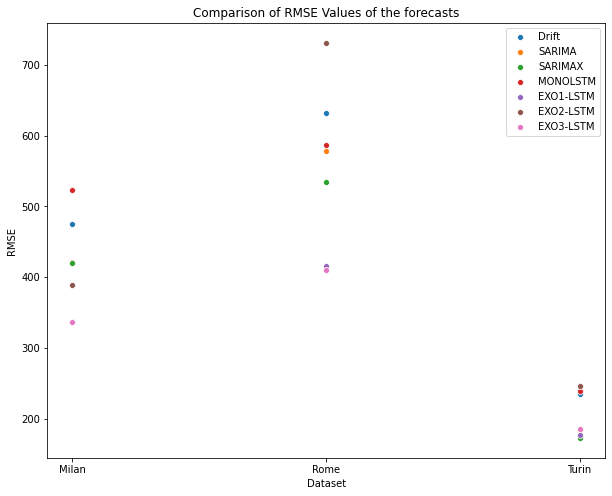

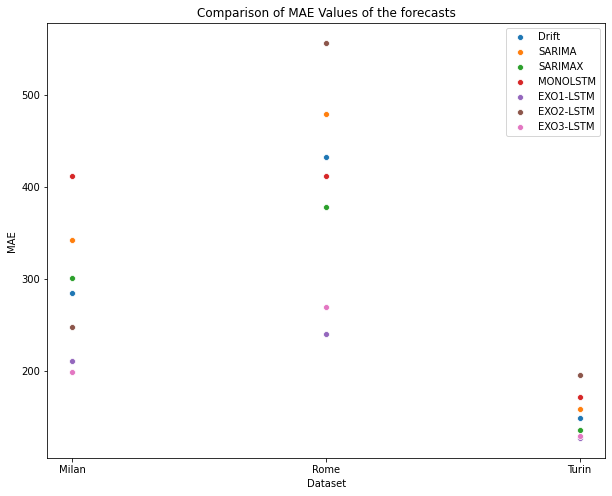

In [12]:
# Graphic comparison of error values: RMSE
plt.figure(figsize=(10,8))
plt.title("Comparison of RMSE Values of the forecasts")
ax = sns.scatterplot(x=mean_results.index, y="DRIFT RMSE", data=mean_results, label="Drift")
ax = sns.scatterplot(x=mean_results.index, y="SARIMA RMSE", data=mean_results, label="SARIMA")
ax = sns.scatterplot(x=mean_results.index, y="SARIMAX RMSE", data=mean_results, label="SARIMAX")
ax = sns.scatterplot(x=mean_results.index, y="MONO-LSTM RMSE", data=mean_results, label="MONOLSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO1-LSTM RMSE", data=mean_results, label="EXO1-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO2-LSTM RMSE", data=mean_results, label="EXO2-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO3-LSTM RMSE", data=mean_results, label="EXO3-LSTM")
ax.set(ylabel="RMSE")
plt.show()

# Graphic comparison of error values: MAE
plt.figure(figsize=(10,8))
plt.title("Comparison of MAE Values of the forecasts")
aax = sns.scatterplot(x=mean_results.index, y="DRIFT MAE", data=mean_results, label="Drift")
aax = sns.scatterplot(x=mean_results.index, y="SARIMA MAE", data=mean_results, label="SARIMA")
aax = sns.scatterplot(x=mean_results.index, y="SARIMAX MAE", data=mean_results, label="SARIMAX")
aax = sns.scatterplot(x=mean_results.index, y="MONO-LSTM MAE", data=mean_results, label="MONOLSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO1-LSTM MAE", data=mean_results, label="EXO1-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO2-LSTM MAE", data=mean_results, label="EXO2-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO3-LSTM MAE", data=mean_results, label="EXO3-LSTM")
aax.set(ylabel="MAE")
plt.show()